# Fractal Dimension of Dielectric Breakdown

We follow the paper by Niemeyer et al., Physical Review Letters 52(12) 1033 1984.

Copyright (C) 2025 Anton Schwarz

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from tqdm import tqdm
from pathlib import Path

In [2]:
output_path = Path("outputs")

In [3]:
def solve_laplace_eqn(img: np.ndarray) -> np.ndarray:
    # Initialize solution array
    # initialising them to 0 is problematic because one of our boundary conditions is 0
    u = np.ones_like(img) * 0.5

    # Dirichlet boundary conditions
    u[img == 1] = 0   # set accessed pixels to have potential 0
    u[img == 2] = 1   # set circular boundary pixels to have potential 1

    # Gauss-Seidel iteration
    tolerance = 1e-3  # set quite high to speed up
    omega = 1.9  # over-relaxation parameter
    max_iter = 5000
    for iteration in range(max_iter):
        u_old = u.copy()

        # Update interior points using the Laplace equation
        for i, j in np.argwhere(img == 0):
            # Over-relaxation
            u_new = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])
            u[i, j] = (1 - omega) * u[i, j] + omega * u_new

        # Check convergence
        if np.max(np.abs(u - u_old)) < tolerance:
            # print(f"Converged in {iteration} iterations")
            break
    
    # overrelaxation might lead to slightly negative values
    # clip so that they can still be interpreted as unnormalised pdf
    return np.clip(u, 0, 1)

In [4]:
def choose_new_point(img: np.ndarray, u: np.ndarray, eta: float) -> tuple[int, int]:
    """
    Takes the candidate points (i.e. 4-connected points surrounding the pattern)
    and selects the coordinates where to put the next pixel. The choice is made
    by sampling from the normalised potential distribution u.
    """
    # 4-connected stencil
    structure = np.array([[0, 1, 0],
                        [1, 1, 1],
                        [0, 1, 0]], dtype=bool)
    # candidate mask: dilated pattern but not the pattern itself
    candidate_mask = np.logical_and(binary_dilation(img == 1, structure), img != 1)
    # perform power law relationship: u^eta
    u_eta = np.power(u, eta)
    # choose and return coordinate, taken from normalised potential distribution u on the candidate_mask
    _choicenum = np.random.choice(np.arange(candidate_mask.sum()), p=u_eta[candidate_mask] / u_eta[candidate_mask].sum())
    choice = np.argwhere(candidate_mask)[_choicenum]
    return (int(choice[0]), int(choice[1]))

In [26]:
def make_image_and_save(img: np.ndarray, step: int, size: int, eta: int):
    """
    save data as png with metadata encoded in title
    you can make a video from it later
    """
    plt.imshow(
        img == 1,
        origin="lower",
        cmap="gray"
    )
    plt.title(f"Frame {step}, $\\eta = {eta}$")
    plt.axis("off")
    plt.savefig(output_path / f"eta_{eta}_size{size}_step{step:03}.png", bbox_inches="tight")
    plt.close()

In [24]:
# Initialisation
SIZE = 70 
N_STEPS = 100
ETA = 1.2  # power law relationship between attachment probability and local potential


coords = (np.indices((SIZE, SIZE)) - SIZE // 2)
X, Y = coords
img = np.zeros((SIZE, SIZE), dtype=np.uint8)
img[(X == 0) & (Y == 0)] = 1  # set center pixel to be the seed of the growing pattern
img[X**2 + Y**2 >= (SIZE * 0.9/2)**2] = 2  # set pixels outside of a circle to value 2 (i.e. boundary condition)

In [25]:
for i in tqdm(range(N_STEPS)):
    # calculation step
    u = solve_laplace_eqn(img)
    # choice step
    choice = choose_new_point(img, u, ETA)
    # update step
    if img[*choice] == 2:
        print("Reached outer limit of accessible area, stopping.")
        break
    img[*choice] = 1
    make_image_and_save(img, i, SIZE, ETA)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


Note that need to compile the pngs into an mp4 now, e.g. by using this command (replace `<ETA>` and `<SIZE>` with the appropriate values):
`ffmpeg -r 30 -i eta_<ETA>_size<SIZE>_step%03d.png -vf "scale=ceil(in_w/2)*2:ceil(in_h/2)*2" -vcodec libx264 -crf 18 -pix_fmt yuv420p output.mp4`

## Example Visualisations

### Image State

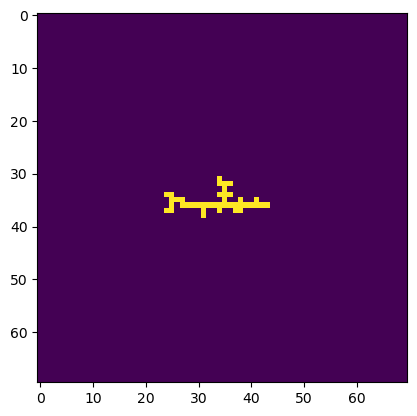

In [20]:
plt.imshow(img == 1)

### Candidate Mask

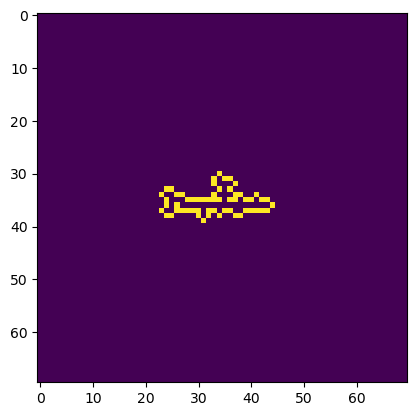

In [22]:
structure = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]], dtype=bool)
candidate_mask = np.logical_and(binary_dilation(img == 1, structure), img != 1)
plt.imshow(candidate_mask)

### Solving Laplace Equation

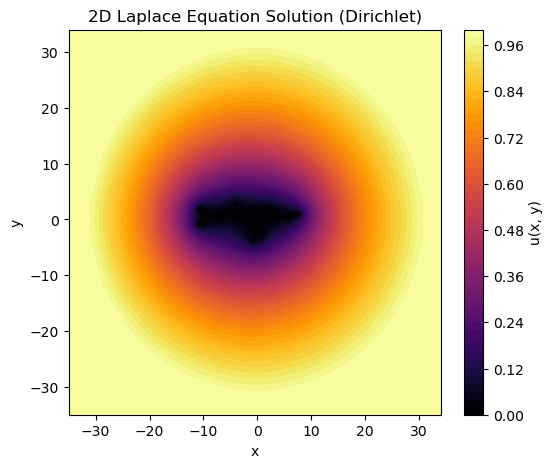

In [21]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, u.T, levels=50, cmap='inferno')
plt.colorbar(label="u(x, y)")
plt.title("2D Laplace Equation Solution (Dirichlet)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()